In oure last notebook( [Part1_Plant_Classification_EDA](https://github.com/Mohammad-Amirifard/Plant-Classification-Polimi/blob/main/Part1_Plant_Classification_EDA.ipynb)), we made our dataset clean, without outliers and duplicates. Now we are working with clean_plant_dataset.npz which is avaiable here: [Link](https://drive.google.com/drive/folders/1CzLGEZA7S0WhyVMTMUM-j4J6ptd6WyOx?usp=drive_link)

### 1-Mount Google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive') # mount google drive to /content directory

Mounted at /content/drive


####1-1 copy clea dataset to /content direcory

In [2]:
# Here, /content/drive/MyDrive/Projects/Plant Classification Polimi/Dataset/clean_plant_dataset.npz is the address of clean data in my drive. You must replace it with yours.
!cp  "/content/drive/MyDrive/clean_plant_dataset.npz" "/content"

### 2-Import Libraries

In [3]:
import os, warnings,logging,cv2, keras
from skimage.color import rgb2lab, deltaE_cie76
import numpy as np
import tensorflow as tf
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from tensorflow.keras import callbacks
from tensorflow.keras.utils import to_categorical
from keras import models, layers
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

### 3-Fix randomness and hide warnings

In [4]:
seed = 42
#####
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'
#####
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

### 4-Set first parameters of tensorflow

In [5]:
# Import tensorflow
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print("tensorflow_version",tf.__version__)

tensorflow_version 2.14.0


### 5-Load dataset

In [6]:
dataset = np.load("/content/clean_plant_dataset.npz", allow_pickle=True)

In [7]:
keys = list(dataset.keys())
print('keys in our dataset are: ', keys)
print('*'*100)

keys in our dataset are:  ['clean_x', 'clean_y']
****************************************************************************************************


In [8]:
# Watch keys available in the numpy array
keys = list(dataset.keys())
print('keys in our dataset are: ', keys)
print('*'*100)

# look at data shape
data = dataset["clean_x"]
no_images = data.shape[0]
size_images = data.shape[1:3]
print('Data shape: ',data.shape)
print('*'*100)

# Lool aat labels
labels = dataset["clean_y"]
no_labels = labels.shape[0]
print("Labels are : ",labels)
print('*'*100)

# Look at bing balanced or imbalanced
_, counts = np.unique(labels,return_counts=True) # count occurrence of each item
no_healthy_images = counts[0]
no_unhealthy_images = counts[1]

# pass variables to a dictionary to be used as dataframe for a better show
info_table_dict = {"no_images":no_images, "image_width": size_images[0],"image_length": size_images[1], "no_labels":no_labels,
                   "no_healthy_images":no_healthy_images,"percentage%":no_healthy_images*100/no_labels,
                   "no_unhealthy_images":no_unhealthy_images,"percentage %":no_unhealthy_images*100/no_labels }
info_table = pd.DataFrame(info_table_dict, index =['value'])
info_table

keys in our dataset are:  ['clean_x', 'clean_y']
****************************************************************************************************
Data shape:  (4850, 96, 96, 3)
****************************************************************************************************
Labels are :  [0 0 0 ... 0 0 0]
****************************************************************************************************


,no_images,image_width,image_length,no_labels,no_healthy_images,percentage%,no_unhealthy_images,percentage %
value,4850,96,96,4850,3060,63.092784,1790,36.907216


### 6-Split data into training, valdiation and testing blocks

In [9]:
# Split the dataset into training and test sets
x_train_data, x_test, y_train_data, y_test = train_test_split(
    data,
    labels,
    test_size = 0.2,
    shuffle =True,
    random_state=seed,
    stratify=labels
)

In [10]:
# Further split the combined training and validation set into a training set and a validation set
x_train, x_val, y_train, y_val = train_test_split(
    x_train_data,
    y_train_data,
    test_size = len(x_test), # Ensure validation set size matches test set size--> Why??
    random_state=seed,
    shuffle =True,
    stratify=y_train_data
)

In [11]:
# Print the shapes of different datsets after splitting the main dataset into training, validation, testing parts
print('X_train.shape:',x_train.shape,'y_train.shape:', y_train.shape)
print('X_val.shape:',x_val.shape, 'y_val.shape:',y_val.shape)
print('X_test.shape:',x_test.shape,'y_test.shape', y_test.shape)

X_train.shape: (2910, 96, 96, 3) y_train.shape: (2910,)
X_val.shape: (970, 96, 96, 3) y_val.shape: (970,)
X_test.shape: (970, 96, 96, 3) y_test.shape (970,)


### 7-Watch data distribution in three blocks

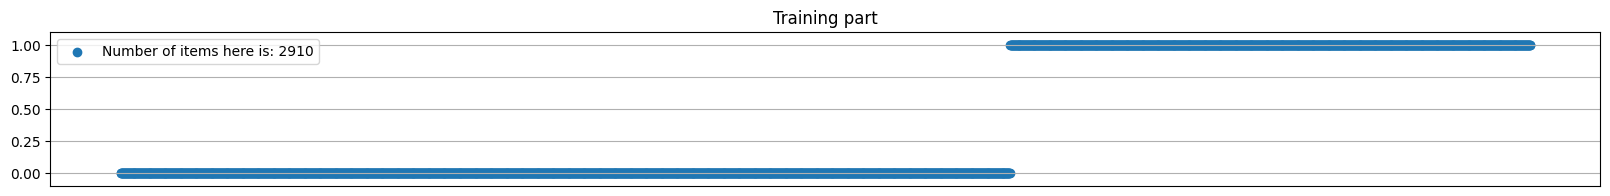

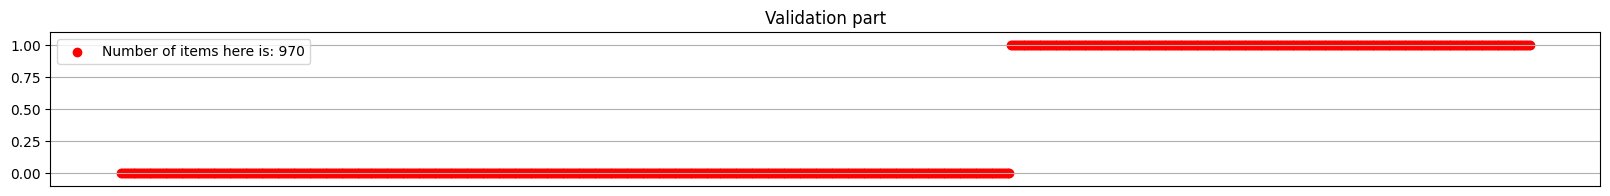

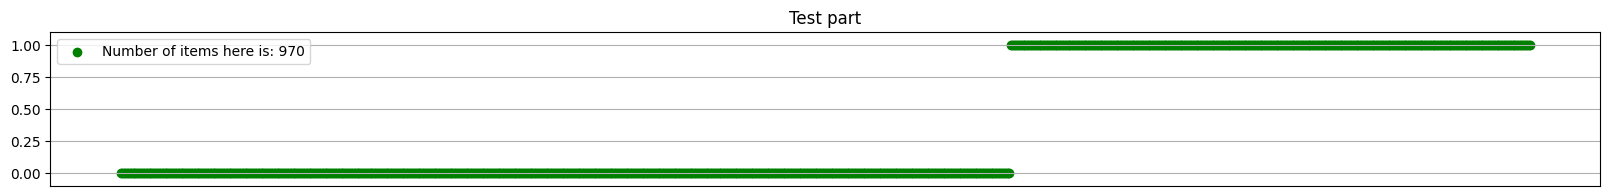

In [12]:
# Create three separate subplots to visualize the sorted target variable values for the training, validation, and test sets

# Create a figure for the training labels subplot
plt.figure(figsize=(20, 2))
plt.scatter((np.arange(y_train.shape[0])), np.sort(y_train, axis=0), label=f'Number of items here is: {y_train.shape[0]}')
plt.title('Training part')
plt.xticks([])  # Remove x-axis ticks
plt.grid(0.2)   # Add a grid with opacity 0.2 for reference
plt.ylim([-0.1, 1.1])  # Set the y-axis limits to [0.1, 1.1]
plt.legend()

# Create a figure for the validation labels subplot
plt.figure(figsize=(20, 2))
plt.scatter(np.arange(y_val.shape[0]), np.sort(y_val, axis=0),color='red',label=f'Number of items here is: {y_val.shape[0]}')
plt.title('Validation part')
plt.xticks([])  # Remove x-axis ticks
plt.grid(0.2)   # Add a grid with opacity 0.2 for reference
plt.ylim([-0.1, 1.1])  # Set the y-axis limits to [0.1, 1.1]
plt.legend()

# Create a figure for the test labels subplot
plt.figure(figsize=(20, 2))
plt.scatter(np.arange(y_test.shape[0]), np.sort(y_test, axis=0),color='green', label=f'Number of items here is: {y_test.shape[0]}')
plt.title('Test part')
plt.xticks([])  # Remove x-axis ticks
plt.grid(0.2)   # Add a grid with opacity 0.2 for reference
plt.ylim([-0.1, 1.1])  # Set the y-axis limits to [0.1, 1.1]
plt.legend()

# Display the plots
plt.show()

### 8- Feature Scaling

In [13]:
# In order to have a better result, we do feature scaling.
x_train = x_train/255.0
x_val = x_val/255.0
x_test = x_test/255.0

### 9-Callbacks

In [14]:
def Checkpoint(address):

  # CheckPoint callback ---> to save wieghts
  checkpoint_path = address # The path to save wights of the model after training
  My_ModelCheckpoint_callback =callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                          monitor='val_accuracy',
                                          verbose=1,
                                          save_weights_only=False,
                                          save_best_only=True,
                                          mode='max',
                                          save_freq ='epoch')
  return My_ModelCheckpoint_callback

##############################################################################
def earlystopping():

  # EarlyStopping callback --> Stop learning if it does not see any imporvement.
  My_EarlyStopping_callback = callbacks.EarlyStopping(monitor="val_accuracy",
                                                  min_delta=.02,
                                                  patience=25,
                                                  verbose=1,
                                                  mode="max",
                                                  restore_best_weights=True)
  return My_EarlyStopping_callback

### 10-Plot accuracy

In [15]:
def plot_accuracy(history_dict):
  plt.figure(figsize=(21, 4))
  accuracy_colors = ['#a1c9f4', '#ffc58a', '#9ae6a0', '#f6a1a1', '#c3b9d0',
                  '#bf9a8a', '#f1c7e6', '#c0c0c0', '#e3e0a7', '#8edbf0']

  val_accuracy_colors = ['#0e5a8d', '#c1680a', '#1d6c1d', '#861b1b', '#594173',
                 '#513c34', '#a85894', '#595959', '#7f7d12', '#0e688c']
  index = 0
  for name in history_dict.keys():
      plt.plot(history_dict[name]['accuracy'], label=f"{name}_accuracy", alpha=0.8,color=accuracy_colors[index])
      plt.plot(history_dict[name]['val_accuracy'], label=f"{name}_val_accuracy", alpha=0.8,color=val_accuracy_colors[index])
      index+=1

  plt.title("Graphs")
  plt.legend()
  plt.xlabel('Epochs')
  plt.ylabel('Validation Accuracy')
  plt.grid(alpha=0.3)
  plt.show()

# Example usage:
# history_dict = {'model1': {'val_accuracy': [0.5, 0.6, 0.7, 0.8]},
#                 'model2': {'val_accuracy': [0.4, 0.5, 0.6, 0.7]}}
# plot_accuracy(history_dict)


In [16]:
history_dict ={} # to save history of different models

### 11- Trun labels to categories

In [17]:
# since we use softamx in our models, we turn y to categorical class
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

In [18]:
print("y_train.shape: ",y_train.shape)
print("5 items of y_train in this state:\n ",y_train[:5])

y_train.shape:  (2910, 2)
5 items of y_train in this state:
  [[1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]]


###12-Hyperparameters

In [19]:
# Define the input shape for the neural network, excluding the batch size
input_shape = x_train.shape[1:]
print('input_shape',input_shape)

# Define the batch size for training
batch_size = 64

# Define the number of training epochs and learning_rate
epochs = 100
learning_rate = 1e-3


input_shape (96, 96, 3)


### 12- Simple Convolutional Neural Networks(SCNN)

####12-1 Define Model

In [20]:
def SCNN(input_shape=input_shape):

  '''This Simple CNN netowrk includes 3 convlutional networks+ 1 flatten layers+ 1full connetced layer + 1 classifier layer'''



  model = models.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='relu',
                          input_shape= input_shape))

  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.Conv2D(128, (3, 3), activation='relu'))
  model.add(layers.Flatten())
  model.add(layers.Dense(10, activation='relu'))
  model.add(layers.Dense(2, activation='softmax'))

  return model

####12-2 Compile Model

In [21]:
SCNN = SCNN()
SCNN.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              metrics=[keras.metrics.Precision(), keras.metrics.Recall(),'accuracy'],)

In [22]:
SCNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 94, 94, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 92, 92, 64)        18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 90, 90, 128)       73856     
                                                                 
 flatten (Flatten)           (None, 1036800)           0         
                                                                 
 dense (Dense)               (None, 10)                10368010  
                                                                 
 dense_1 (Dense)             (None, 2)                 22        
                                                                 
Total params: 10461280 (39.91 MB)
Trainable params: 1046

####12-3 Fit model

In [23]:
SCNN = SCNN.fit(
    x = x_train,
    y = y_train,
    validation_data = (x_val, y_val),
    batch_size = batch_size,
    epochs = epochs
)

Epoch 1/100
46/46 [==============================] - 20s 139ms/step - loss: 0.7274 - precision: 0.6131 - recall: 0.6131 - accuracy: 0.6131 - val_loss: 0.6726 - val_precision: 0.6309 - val_recall: 0.6309 - val_accuracy: 0.6309
Epoch 2/100
46/46 [==============================] - 5s 98ms/step - loss: 0.6558 - precision: 0.6309 - recall: 0.6309 - accuracy: 0.6309 - val_loss: 0.6298 - val_precision: 0.6309 - val_recall: 0.6309 - val_accuracy: 0.6309
Epoch 3/100
46/46 [==============================] - 5s 98ms/step - loss: 0.6119 - precision: 0.6309 - recall: 0.6309 - accuracy: 0.6309 - val_loss: 0.6143 - val_precision: 0.6309 - val_recall: 0.6309 - val_accuracy: 0.6309
Epoch 4/100
46/46 [==============================] - 5s 101ms/step - loss: 0.5595 - precision: 0.6670 - recall: 0.6670 - accuracy: 0.6670 - val_loss: 0.6242 - val_precision: 0.6722 - val_recall: 0.6722 - val_accuracy: 0.6722
Epoch 5/100
46/46 [==============================] - 5s 101ms/step - loss: 0.4963 - precision: 0.7735

####12-4 Store its history

In [24]:
history_dict['SCNN'] = SCNN.history

### 13-Effect Of Maxpooling(SCNNM)
2nd model is similar to the privious simple convlutional model besides maxpooling layers


####13-1 Define model

In [25]:
def SCNNM(input_shape=input_shape):
  '''This Simple CNN netowrk includes 3 convlutional networks+ 1 flatten layers+ 1full connetced layer + 1 classifier layer'''

  model = models.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='relu',
                          input_shape= input_shape))
  model.add(layers.MaxPooling2D((2, 2)))

  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))

  model.add(layers.Conv2D(128, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))

  model.add(layers.Conv2D(128, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))

  model.add(layers.Flatten())

  model.add(layers.Dense(512, activation='relu'))
  model.add(layers.Dense(2, activation='softmax'))

  return model

####13-2 Compile model

In [26]:
SCNNM = SCNNM()
SCNNM.compile(loss=tfk.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              metrics=[keras.metrics.Precision(), keras.metrics.Recall(),'accuracy'],)

In [27]:
SCNNM.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 94, 94, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 47, 47, 32)        0         
 D)                                                              
                                                                 
 conv2d_4 (Conv2D)           (None, 45, 45, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 22, 22, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 20, 20, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 10, 10, 128)      

####13-3 Fit model

In [28]:
SCNNM = SCNNM.fit(
    x = x_train,
    y = y_train,
    validation_data = (x_val, y_val),
    batch_size = batch_size,
    epochs = epochs
)

Epoch 1/100
46/46 [==============================] - 5s 43ms/step - loss: 0.6775 - precision_1: 0.6254 - recall_1: 0.6254 - accuracy: 0.6254 - val_loss: 0.6581 - val_precision_1: 0.6309 - val_recall_1: 0.6309 - val_accuracy: 0.6309
Epoch 2/100
46/46 [==============================] - 1s 24ms/step - loss: 0.6592 - precision_1: 0.6309 - recall_1: 0.6309 - accuracy: 0.6309 - val_loss: 0.6521 - val_precision_1: 0.6309 - val_recall_1: 0.6309 - val_accuracy: 0.6309
Epoch 3/100
46/46 [==============================] - 1s 25ms/step - loss: 0.6487 - precision_1: 0.6320 - recall_1: 0.6320 - accuracy: 0.6320 - val_loss: 0.6496 - val_precision_1: 0.6495 - val_recall_1: 0.6495 - val_accuracy: 0.6495
Epoch 4/100
46/46 [==============================] - 1s 25ms/step - loss: 0.6252 - precision_1: 0.6701 - recall_1: 0.6701 - accuracy: 0.6701 - val_loss: 0.6141 - val_precision_1: 0.6804 - val_recall_1: 0.6804 - val_accuracy: 0.6804
Epoch 5/100
46/46 [==============================] - 1s 25ms/step - loss

####13-4 Store its history

In [29]:
history_dict['SCNNM'] = SCNNM.history

###14- Effect Of Dropout
3rd model is similar to the privious one besides Droput layers(SCNNMD)

####14-1 Define model

In [30]:
def SCNNMD(input_shape=input_shape):

  model = models.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='relu',
                          input_shape= input_shape))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.Dropout(0.2))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(128, (3, 3), activation='relu'))
  model.add(layers.Dropout(0.3))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(128, (3, 3), activation='relu'))
  model.add(layers.Dropout(0.4))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Flatten())
  model.add(layers.Dense(512, activation='relu'))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(2, activation='softmax'))

  return model

####14-2 Complie model

In [31]:
SCNNMD = SCNNMD()
SCNNMD.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              metrics=[keras.metrics.Precision(), keras.metrics.Recall(),'accuracy'],)

####14-3 Fit model

In [32]:
SCNNMD = SCNNMD.fit(
    x = x_train,
    y = y_train,
    validation_data = (x_val, y_val),
    batch_size = batch_size,
    epochs = epochs
)

Epoch 1/100
46/46 [==============================] - 5s 46ms/step - loss: 0.6614 - precision_2: 0.6244 - recall_2: 0.6244 - accuracy: 0.6244 - val_loss: 0.6784 - val_precision_2: 0.6309 - val_recall_2: 0.6309 - val_accuracy: 0.6309
Epoch 2/100
46/46 [==============================] - 1s 32ms/step - loss: 0.6604 - precision_2: 0.6292 - recall_2: 0.6292 - accuracy: 0.6292 - val_loss: 0.6624 - val_precision_2: 0.6309 - val_recall_2: 0.6309 - val_accuracy: 0.6309
Epoch 3/100
46/46 [==============================] - 1s 31ms/step - loss: 0.6414 - precision_2: 0.6392 - recall_2: 0.6392 - accuracy: 0.6392 - val_loss: 0.6287 - val_precision_2: 0.6588 - val_recall_2: 0.6588 - val_accuracy: 0.6588
Epoch 4/100
46/46 [==============================] - 2s 36ms/step - loss: 0.6198 - precision_2: 0.6667 - recall_2: 0.6667 - accuracy: 0.6667 - val_loss: 0.6162 - val_precision_2: 0.6773 - val_recall_2: 0.6773 - val_accuracy: 0.6773
Epoch 5/100
46/46 [==============================] - 2s 38ms/step - loss

####14-4 Store history

In [33]:
history_dict['SCNNMD'] = SCNNMD.history

### 15-Effect of Early Stopping(SCNNMDE)
4th model is similar to the privious one besides early stopping

####15-1 Define model

In [34]:
def SCNNMDE(input_shape=input_shape):


  model = models.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='relu',
                          input_shape= input_shape))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.Dropout(0.2))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(128, (3, 3), activation='relu'))
  model.add(layers.Dropout(0.3))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(128, (3, 3), activation='relu'))
  model.add(layers.Dropout(0.4))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Flatten())
  model.add(layers.Dense(512, activation='relu'))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(2, activation='softmax'))

  return model

####15-2 Compile model

In [35]:
SCNNMDE = SCNNMDE()
SCNNMDE.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              metrics=[keras.metrics.Precision(), keras.metrics.Recall(),'accuracy'],)

####15-3 Fit model

In [36]:
My_all_callbacks = [earlystopping(),Checkpoint("/content/SCNNMDE")] # Use early stopping and checkpoint
SCNNMDE = SCNNMDE.fit(
    x = x_train,
    y = y_train,
    validation_data = (x_val, y_val),
    batch_size = batch_size,
    epochs = epochs,
    callbacks=My_all_callbacks
)

Epoch 1/100
45/46 [============================>.] - ETA: 0s - loss: 0.6675 - precision_3: 0.6253 - recall_3: 0.6253 - accuracy: 0.6253
Epoch 1: val_accuracy improved from -inf to 0.63093, saving model to /content/SCNNMDE
46/46 [==============================] - 5s 79ms/step - loss: 0.6675 - precision_3: 0.6251 - recall_3: 0.6251 - accuracy: 0.6251 - val_loss: 0.6722 - val_precision_3: 0.6309 - val_recall_3: 0.6309 - val_accuracy: 0.6309
Epoch 2/100
45/46 [============================>.] - ETA: 0s - loss: 0.6615 - precision_3: 0.6323 - recall_3: 0.6323 - accuracy: 0.6323
Epoch 2: val_accuracy did not improve from 0.63093
46/46 [==============================] - 2s 33ms/step - loss: 0.6620 - precision_3: 0.6309 - recall_3: 0.6309 - accuracy: 0.6309 - val_loss: 0.6665 - val_precision_3: 0.6309 - val_recall_3: 0.6309 - val_accuracy: 0.6309
Epoch 3/100
45/46 [============================>.] - ETA: 0s - loss: 0.6568 - precision_3: 0.6306 - recall_3: 0.6306 - accuracy: 0.6306
Epoch 3: val_ac

####15-4 Store its history

In [37]:
history_dict['SCNNMDE'] = SCNNMDE.history

### 16-Effect Of Data Augmentation(SCNNMDED)
5th model is similar to the privious one besides data augmentation

####16-1 Data Augmentation

In [38]:
preprocessing = tf.keras.Sequential([
      tfkl.RandomBrightness(0.2, value_range=(0,1)),
      tfkl.RandomTranslation(0.2,0.2),

  ], name='preprocessing')

####16-2 Define model

In [39]:
def SCNNMDED(input_shape=input_shape):
  global preprocessing


  input_layer = tfkl.Input(shape=input_shape, name='Input')
  preprocessing = preprocessing(input_layer)


  x = tfkl.Conv2D(filters=32, kernel_size=3, name='conv0')(preprocessing)
  x = tfkl.ReLU(name='relu0')(x)
  x = tfkl.MaxPooling2D((2,2),name='mp0')(x)
  x = tfkl.Dropout(0.25)(x)

  x = tfkl.Conv2D(filters=64, kernel_size=3, name='conv1')(x)
  x = tfkl.ReLU(name='relu1')(x)
  x = tfkl.MaxPooling2D((2,2),name='mp1')(x)
  x = tfkl.Dropout(0.25)(x)

  x = tfkl.Conv2D(filters=128, kernel_size=3, name='conv2')(x)
  x = tfkl.ReLU(name='relu2')(x)
  x = tfkl.MaxPooling2D((2,2),name='mp2')(x)
  x = tfkl.Dropout(0.25)(x)

  x = tfkl.Conv2D(filters=128, kernel_size=3, name='conv3')(x)
  x = tfkl.ReLU(name='relu3')(x)
  x = tfkl.MaxPooling2D((2,2),name='mp3')(x)
  x = tfkl.Dropout(0.25)(x)

  x = tfkl.Flatten()(x)
  dense = tfkl.Dense(units=512, activation='relu',name='dense')(x)
  output_layer = tfkl.Dense(units=2, activation='Softmax',name='outpu_layer')(dense)

   # Connect input and output through the Model class
  model = tfk.Model(inputs=input_layer, outputs=output_layer, name='CNN')

  return model

####16-3 Compile model

In [40]:
SCNNMDED = SCNNMDED()
SCNNMDED.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              metrics=[keras.metrics.Precision(), keras.metrics.Recall(),'accuracy'],)

####16-4 Fit model

In [41]:
My_all_callbacks = [earlystopping(),Checkpoint("/content/SCNNMDED")] # Use early stopping and checkpoint
SCNNMDED = SCNNMDED.fit(
    x = x_train,
    y = y_train,
    validation_data = (x_val, y_val),
    batch_size = batch_size,
    epochs = epochs,
    callbacks=My_all_callbacks
)

Epoch 1/100
45/46 [============================>.] - ETA: 0s - loss: 0.6940 - precision_4: 0.6062 - recall_4: 0.6062 - accuracy: 0.6062
Epoch 1: val_accuracy improved from -inf to 0.63093, saving model to /content/SCNNMDED
46/46 [==============================] - 9s 91ms/step - loss: 0.6939 - precision_4: 0.6062 - recall_4: 0.6062 - accuracy: 0.6062 - val_loss: 0.6703 - val_precision_4: 0.6309 - val_recall_4: 0.6309 - val_accuracy: 0.6309
Epoch 2/100
45/46 [============================>.] - ETA: 0s - loss: 0.6600 - precision_4: 0.6323 - recall_4: 0.6323 - accuracy: 0.6323
Epoch 2: val_accuracy did not improve from 0.63093
46/46 [==============================] - 2s 33ms/step - loss: 0.6606 - precision_4: 0.6309 - recall_4: 0.6309 - accuracy: 0.6309 - val_loss: 0.6702 - val_precision_4: 0.6309 - val_recall_4: 0.6309 - val_accuracy: 0.6309
Epoch 3/100
45/46 [============================>.] - ETA: 0s - loss: 0.6611 - precision_4: 0.6299 - recall_4: 0.6299 - accuracy: 0.6299
Epoch 3: val_a

####16-5 Store its hisotry

In [42]:
history_dict['SCNNMDED'] = SCNNMDED.history

###17-Comparison

####17-1 Line graph

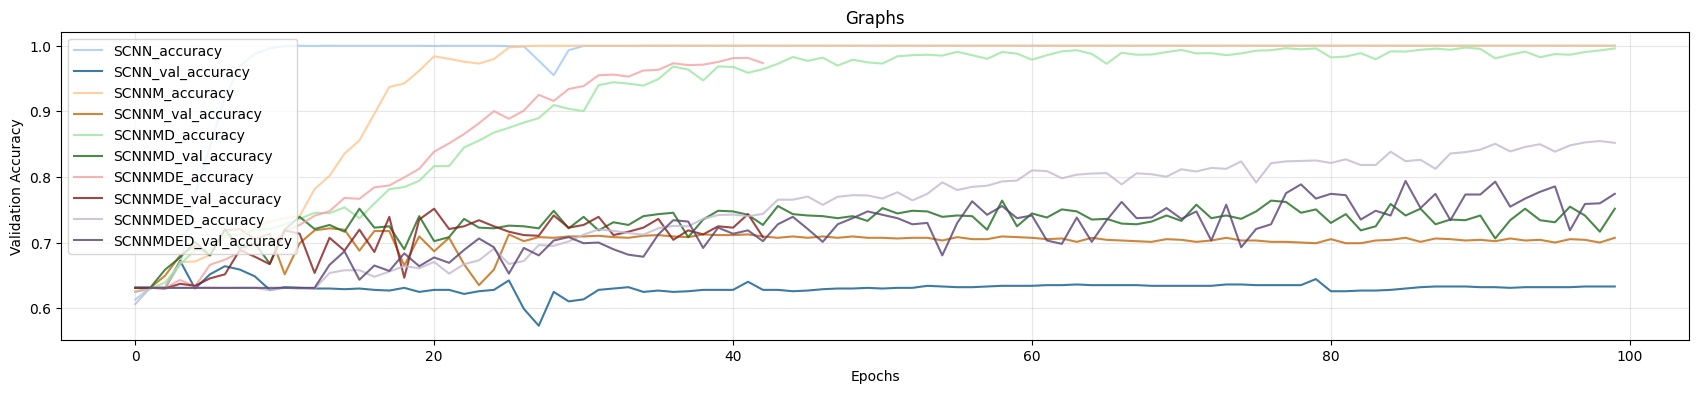

In [43]:
plot_accuracy(history_dict)

####17-2 Bar graph

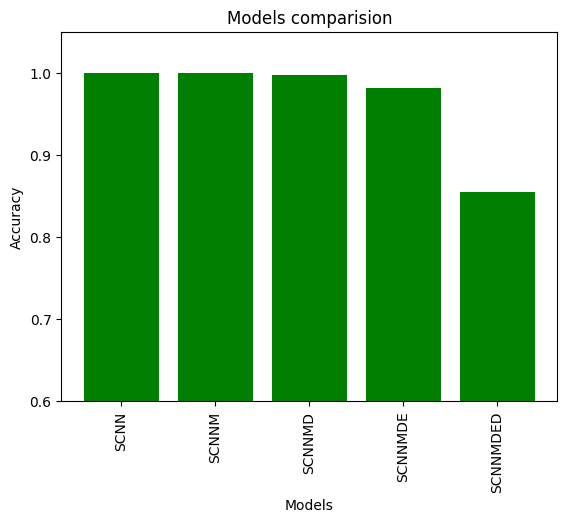

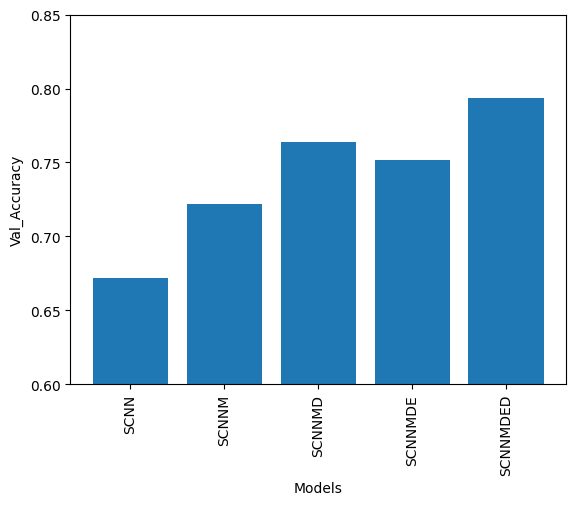

In [44]:
max_val_accuracy = {}
max_accuracy = {}
for model in history_dict.keys():
  max = np.max(history_dict[model]['val_accuracy'])
  max_val_accuracy[model] = max

  max = np.max(history_dict[model]['accuracy'])
  max_accuracy[model] = max

plt.bar(x=max_accuracy.keys(), height=max_accuracy.values(),color='green')
plt.ylim(0.6,1.05)
plt.xticks(rotation=90)
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title('Models comparision')
plt.show()

plt.bar(x=max_val_accuracy.keys(), height=max_val_accuracy.values())
plt.ylim(0.6,.85)
plt.xticks(rotation=90)
plt.xlabel("Models")
plt.ylabel("Val_Accuracy")
plt.show()

###18- Conclusion
We concluded that adding layers like maxpooling and dropout can improve the simple convlutional networks. Although we imporved val_accuracy from 66% to 76%, it needs better models to have a remarkable result in classification plants. Also, it is noticeable that there is a sharp difference between accuracy and validation accuracy in diverse models.Hence, this means we are dealing with overfitting problem. In last step, we used data augmentation, giving us 79% val_accuracy, but it wasn't really successful, since our dataset is imbalance and we know overfitting happened.

**`Let's go to next notebooks, including more advanced models, addressing overfitting problem.`**